# Policy Learning

In this tutorial, we are going to see how to design the most welfare-improving policy in presence of treatment effect heterogeneity and treatment costs or budget constraints.

**Requisites**

For this tutorial, I assume you are familiar with the following concepts:

- Rubin's potential outcome framework
- Propensity weighting or uplifting
- [AIPW or Double Robust Estimators](https://matteocourthoud.github.io/post/aipw/)
- [Causal Trees](https://matteocourthoud.github.io/post/causal_trees/)

**Academic Replication**

We are going to replicate the paper by [Hanna and Olken (2018)](https://www.aeaweb.org/articles?id=10.1257/jep.32.4.201) in which the authors study the optimal allocation of a cash transfer to households in Peru. We slightly twist the original paper by actually assigning the transfer and assuming 100% consumption.

**Business Case**

We are going to study a company that has to decide which consumers to target with ads.

## Setting

We assume that for a set of i.i.d. subjects $i = 1, ..., n$ we observed a tuple $(X_i, T_i, Y_i)$ comprised of 

- a feature vector $X_i \in \mathbb R^n$
- a treatment variable $T_i \in \lbrace 0, 1 \rbrace$
- a response $Y_i \in \mathbb R$

**Assumption 1 : unconfoundedness** (or ignorability, or selection on observables)

$$
\big \lbrace Y_i^{(1)} , Y_i^{(0)} \big \rbrace \ \perp \ T_i \ | \ X_i
$$

i.e. conditional on observable characteristics $X$, the treatment assignment $T$ is as good as random.

**Assumption 2: overlap** (or bounded support)

$$
\exists \eta > 0 \ : \ \eta \leq \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right] \leq 1-\eta
$$

i.e. no observation is deterministically assigned to the treatment or control group. 

## Policy Learning

The objective of policy learning is to decide which people to treat. More explicitly, we want to learn a map from observable characteristics to a (usually binary) policy space.

$$
\pi : \mathcal X \to \lbrace 0, 1 \rbrace
$$

Policy learning is closely related to the **estimation of heterogeneous treatment effects**. In fact, in both settings, we want to investigate how the treatment affects different individuals in different ways. 

The main **difference** between policy learning and the estimation of heterogeneous treatment effects is the objective function. In policy learning, we are acting in a limited resources setting where providing treatment is costly and the cost could depend on individual characteristics. For example, it might be more costly to vaccinate individuals that live in remote areas. Therefore, one might not just want to treat individuals with the largest expected treatment effect, but the ones for whom treatment is most cost-effective.

The utilitarian **value** of a policy $\pi$

$$
V(\pi) = \mathbb E \Big[ Y_i(\pi(X_i)) \Big] = \mathbb E \big[ Y^{(0)}_i \big] + \mathbb E \big[ \tau(X_i) \pi(X_i) \big]
$$

measures the expectation of the potential outcome $Y$ if we were to **assign** treatment $T$ according to policy $\pi$. This expectation can be split into **two parts**:

1. The baseline expected potential outcome $\mathbb E \big[ Y^{(0)}_i \big]$
2. The expected effect of the policy $\mathbb E \big[ \tau(X_i) \pi(X_i) \big]$

The **objective** of policy learning is to learn a policy with high value $V(\pi)$. As part (2) of the formula makes clear, you get a higher value if you treat the people with a high treatment effect $\tau(x)$.

A **simple approach** could be to assign treatment according to a **thresholding rule** $\tau(x) > c$, where $c$ is some cost below which is not worth treating individuals (or there is not enough budget).

However, estimating the conditional average treatment effect (CATE) function $\tau(x)$ and learning a good policy $\pi(x)$ are different **problems**.

- the correct loss function for policy learning is not the mean squared error (MSE) on $\tau(x)$
    - we want to **maximize welfare**!
- the CATE function $\tau(x)$ might not use some features for targeting
    - e.g. **cannot discriminate** based on race or gender
- you don't want to have feature that people can influence 
    - e.g. use a self-reported measure that people can distort
    
We would like to find a **loss function** $L(\pi ; Y_i, X_i, T_i)$ such that

$$
\mathbb E \big[ L(\pi ; Y_i, X_i, T_i) \big] = - V(\pi)
$$

### IPW Loss

[Kitagawa and Tenenov (2018)](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA13288) propose to learn an empirical estimate of the value function using inverse propensity weighting (IPW).

$$
\hat \pi = \arg \max_{\pi} \Big\lbrace \hat V(\pi) : \pi \in \Pi \Big\rbrace
$$

where 

$$
\hat V(\pi) = \frac{ \mathbb I \big(\lbrace T_i = \pi(X_i) \rbrace \big) }{ \mathbb P \big[ \lbrace T_i = \pi(X_i) \rbrace \ \big| \ X_i \big] } Y_i
$$

The authors show that under **unconfoundedness**, if the propensity score $e(x)$ is known and $\Pi$ is not too complex, the value of the estimated policy converges to the optimal value.

Note that this is a **very different problem** from the normal optimization problem with a MSE loss. In fact, we now have a binary argument in the loss function which makes the problem similar to a classification problem, in which we want to classify people into *high gain* and *low gain* categories.

### AIPW Loss

If propensity score $e(x)$ is not known, we can use a **doubly robust estimator**, exactly as for the average treatment effect.

$$
\hat V = \frac{1}{n} \sum_{i=1}^{n} 
\begin{cases}
\hat \Gamma_i \quad &\text{if} \quad \pi(X_i) = 1 
\newline
- \hat \Gamma_i \quad &\text{if} \quad \pi(X_i) = 0
\end{cases}
$$

where

$$
\hat \Gamma_i = \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) + \frac{T_i }{\hat e(X_i)} \left( Y_i - \hat \mu^{(1)}(X_i) \right) - \frac{(1-T_i) }{1-\hat e(X_i)} \left( Y_i - \hat \mu^{(0)}(X_i) \right)
$$

The relationship with AIPW is that $\hat \tau_{AIPW} = \frac{1}{n} \sum_{i=1}^{n} \hat \Gamma_i$. Therefore, the objective function $V(\pi)$ is build so that when we assign treatment to a unit we "gain" the double-robust score $\hat \tau_{AIPW}$, while, if we do not assign treatment, we "pay" the double-robust score $\hat \tau_{AIPW}$.

## Academic Application

For the academic applicaiton, we are going to replicate the paper by [Hanna and Olken (2018)](https://www.aeaweb.org/articles?id=10.1257/jep.32.4.201) in which the authors study the optimal allocation of a cash transfer to households in Peru. We slightly twist the original paper by actually assigning the transfer and assuming 100% consumption.

First, let's load the modified dataset.

In [1]:
from src.utils import *
from src.dgp import dgp_ao18

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
dgp = dgp_ao18()
df = dgp.import_data()
df.head()

,Unnamed: 0,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,...,d_lux_1,d_lux_2,d_lux_3,d_lux_4,d_lux_5,training,h_hhsize,cash_transfer,consumption,welfare
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,211.0000,5.351858
1,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,3,1,420.1389,6.040585
2,2,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,4,0,390.8318,5.968277
3,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,9,0,285.6018,5.654599
4,4,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,8,0,118.0713,4.771289


As we can see, we have a lot of information about individuals in Peru. Crucially for the research question, we observe

- whether the household received a cash transfer, `cash_transfer`
- the household's welfare afterwards, `welfare_post`
    - assuming
    $$
    \text{welfare} = \log (\text{consumption})
    $$

We would like to understand which individuals should be given a transfer, given that the transfer is costly. Let's assume the transfer costs $0.3$ units of welfare.

In [4]:
from econml.policy import DRPolicyForest

cost = 0.3
policy = DRPolicyForest(random_state=1).fit(Y=df[dgp.Y] - cost*df[dgp.T], T=df[dgp.T], X=df[dgp.X])

We can partially visualize the policy by plotting a regression tree for the most important features.

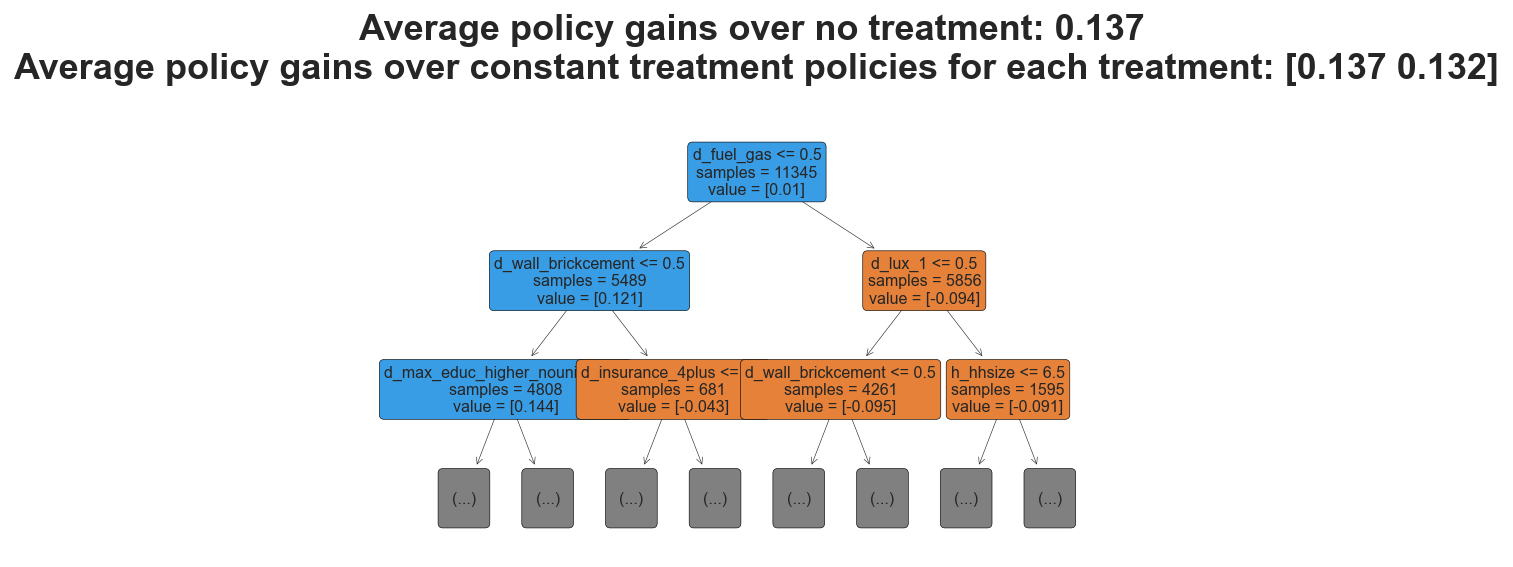

In [5]:
%matplotlib inline
policy.plot(tree_id=1, max_depth=2, feature_names=dgp.X, fontsize=8)

To understand if the estimated policy was effective, we can load the oracle dataset, with the potential outcomes.

In [6]:
df_oracle = dgp.import_data(oracle=True)

From the oracle dataset, we can compute the actual value of the policy.

In [7]:
T_hat = policy.predict(df[dgp.X])
V_policy = (df_oracle['welfare_1'].values - cost - df_oracle['welfare_0'].values) * T_hat
print(f'Estimated policy value (N_T={sum(T_hat)}): {np.mean(V_policy) :.4}')

Estimated policy value (N_T=21401): 0.05897


The value is positive, indicating that the treatment was effective. But how well did we do? We can compare the estimated policy with the oracle policy that assign treatment to each cost-effective unit.

In [8]:
T_oracle = (df_oracle['welfare_1'] - df_oracle['welfare_0']) > cost
V_oracle = (df_oracle['welfare_1'] - cost - df_oracle['welfare_0'] ) * T_oracle
print(f'Oracle policy value (N_T={sum(T_oracle)}): {np.mean(V_oracle) :.4}')

Oracle policy value (N_T=17630): 0.07494


We actually achieved 79% of the potential policy gains! Also note that our policy is too generous, treating more units than optimal. But how well would we have done if the same amount of cash transfers were given at random?

In [9]:
T_rand = np.random.binomial(1, sum(T_hat)/len(df), len(df))
V_rand = (df_oracle['welfare_1'] - cost - df_oracle['welfare_0'] ) * T_rand
print(f'Random policy value (N_T={sum(T_rand)}): {np.mean(V_rand) :.4}')

Random policy value (N_T=21359): 0.0002698


A random assignment of the same amount of cash transfers would not achieve any effect. However, this assumes that we already know the optimal amount of funds to distribute. What if instead we had treated everyone?

In [10]:
V_all = (df_oracle['welfare_1'] - cost - df_oracle['welfare_0'] )
print(f'All-treated policy value (N_T={len(df)}): {np.mean(V_all) :.4}')

All-treated policy value (N_T=45378): 0.0004019


Indiscriminate treatment would again not achieve any effect. Lastly, what if we had just estimated the treatment effect using AIPW and used it as a threshold?

In [11]:
from econml.dr import LinearDRLearner

model = LinearDRLearner(random_state=1).fit(Y=df[dgp.Y], T=df[dgp.T], X=df[dgp.X])
T_ipw = model.effect(X=df[dgp.X], T0=0, T1=1) > cost
V_ipw = (df_oracle['welfare_1'] - cost - df_oracle['welfare_0'] ) * T_ipw
print(f'IPW policy value (N_T={sum(T_ipw)}): {np.mean(V_ipw) :.4}')

IPW policy value (N_T=21003): 0.06293


We are actually doing better! Weird...

## Business Case

We are given the following problem:

> A firm would like to understand which customers to show an ad, in order to increase revenue. The firm ran a A/B test showing a random sample of customers an ad. First, try to understand if there is heterogeneity in treatment. Then, decide which customers to show the ad, given that ads are costly (1\$ each). Further suppose that you cannot discriminate on gender. How do the results change?

We start by drawing a sample from the data generating process.

In [12]:
from src.utils import *
from src.dgp import dgp_ad

In [13]:
dgp = dgp_ad()
df = dgp.generate_data()
df.head()

,male,black,age,educ,ad,revenue
0,0,0,55.0,1,False,-0.327221
1,1,1,47.0,2,False,0.659393
2,0,1,31.0,2,True,2.805178
3,0,1,51.0,2,False,-0.508548
4,0,0,48.0,0,True,0.762280


We have information on the number of pages visited in the previous month, whether the user is located in the US, whether it connects by mobile and the revenue pre-intervention.

We are going to use the [`econml`](https://econml.azurewebsites.net) library to estimate the treatment effects. First, we use the `DRLearner` library to estimate heterogeneous treatment effects using a double robust estimator. We can specify both the `model_propensity` for $e(x)$ and the `model_regression` for $\mu(x)$.

In [14]:
from econml.dr import DRLearner

model = DRLearner(random_state=1).fit(Y=df[dgp.Y], T=df[dgp.T], X=df[dgp.X]);

We can plot a visual representation of the treatment effect heterogeneity using the `SingleTreePolicyInterpreter` function, which infers a tree representation of the treatment effects learned from another model.

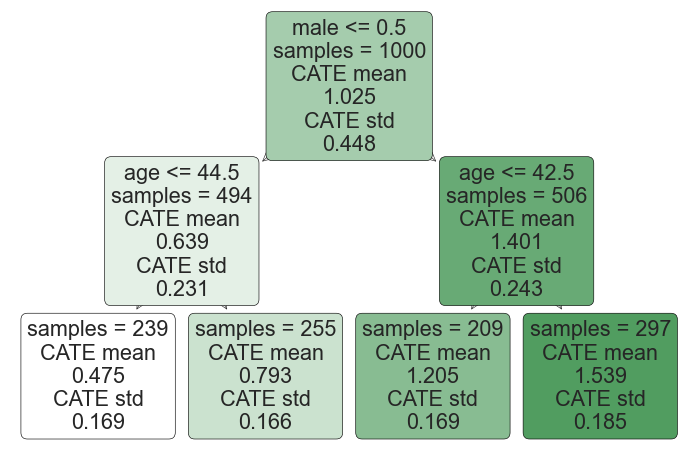

In [15]:
from econml.cate_interpreter import SingleTreeCateInterpreter

SingleTreeCateInterpreter(max_depth=2, random_state=1).interpret(model, X=df[dgp.X]).plot(feature_names=dgp.X)

It seems that the most relevant dimension of treatment heterogeneity is `education`.

We can now use policy learning to estimate a treatment policy. We use the `DRPolicyTree` from the `econml` package.

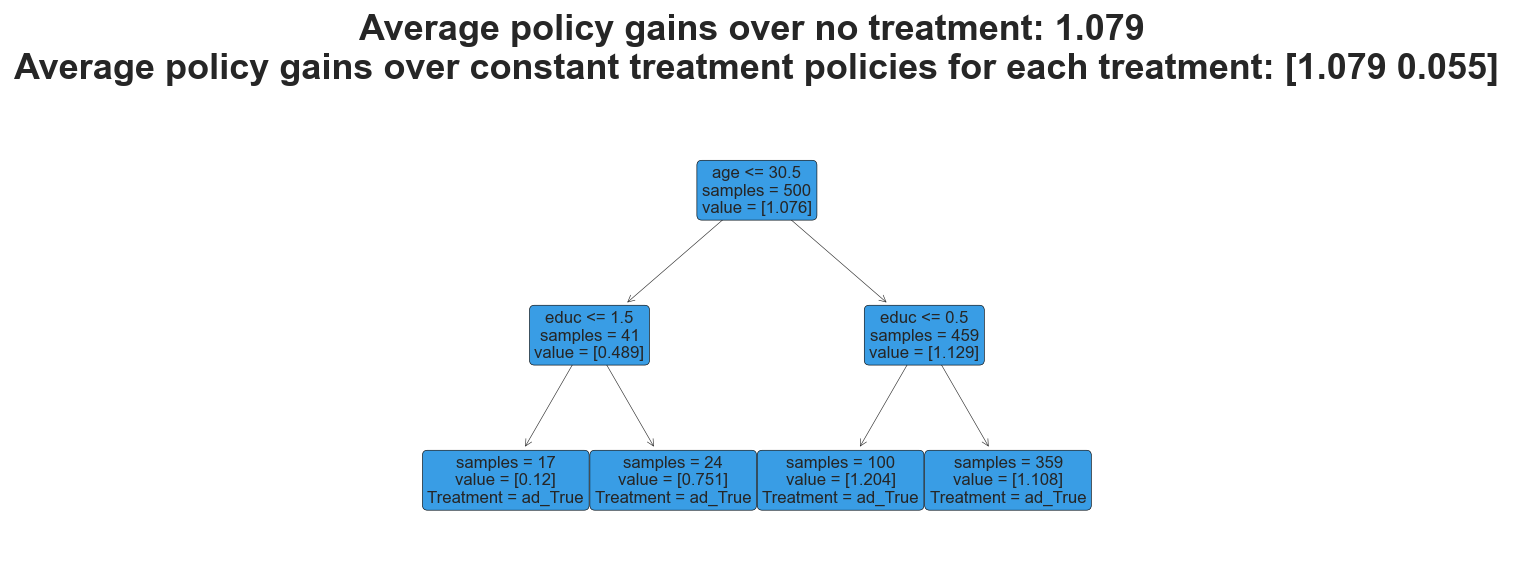

In [16]:
from econml.policy import DRPolicyTree

policy = DRPolicyTree(random_state=1, max_depth=2).fit(Y=df[dgp.Y], T=df[dgp.T], X=df[dgp.X])
policy.plot(feature_names=dgp.X)

We will now assume that the treatment is costly.

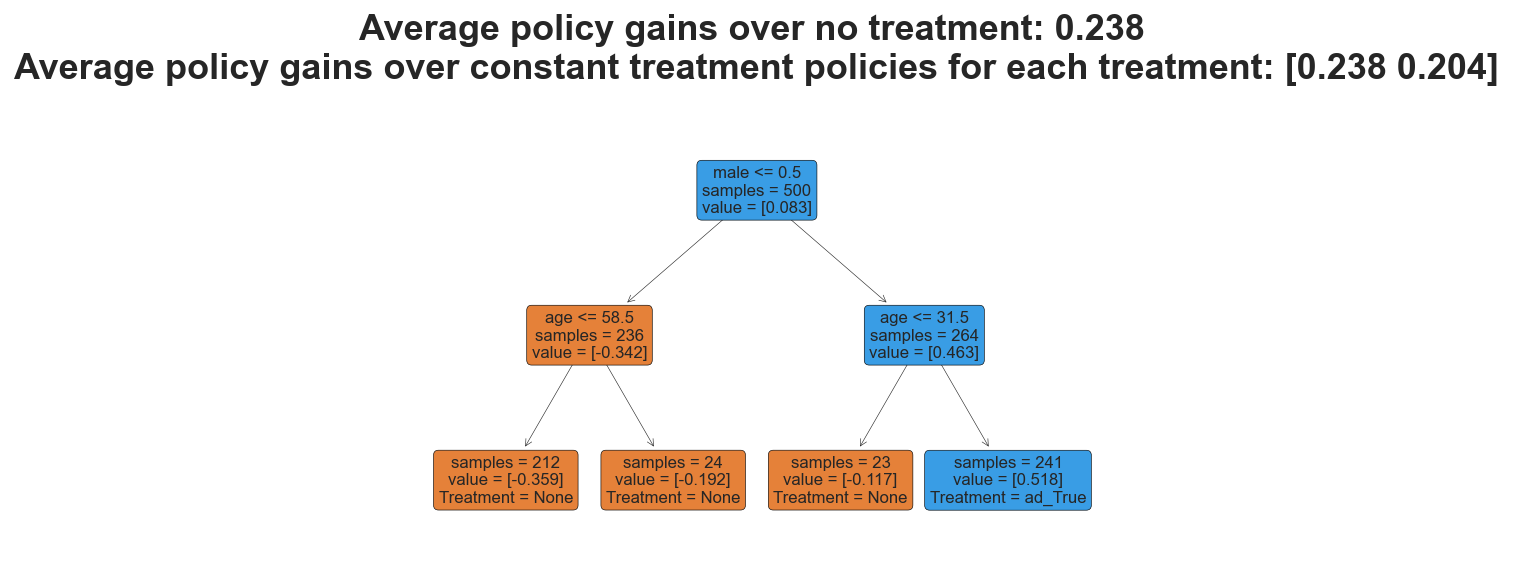

In [17]:
cost = 1
policy = DRPolicyTree(random_state=1, max_depth=2).fit(Y=df[dgp.Y]-cost*df[dgp.T], T=df[dgp.T], X=df[dgp.X])
policy.plot(feature_names=dgp.X)

As we can see, the model decides to use race to discriminate treatment. However, let's now suppose we cannot discriminate on race and gender.

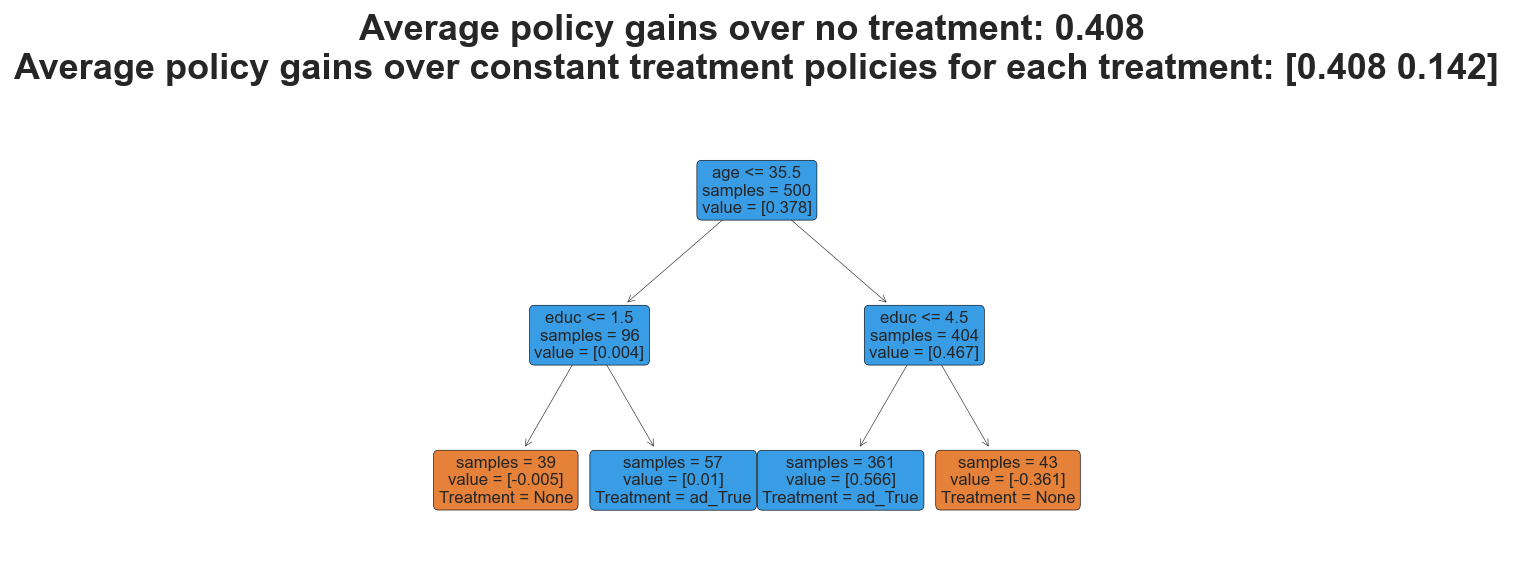

In [18]:
X_short = ['age', 'educ']
policy = DRPolicyTree(random_state=1, max_depth=2).fit(Y=df[dgp.Y]-cost*df[dgp.T], T=df[dgp.T], X=df[X_short])
policy.plot(feature_names=X_short)

In this case, the model uses education instead of race in order to assign treatment.

## References

- [Who Should Be Treated? Empirical Welfare Maximization Methods for Treatment Choice](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA13288) (2018) by Kitagawa and Tetenov
- [Efficient Policy Learning](https://ideas.repec.org/p/ecl/stabus/3506.html) (2017) by Athey and Wager
- [Policy Learning](https://www.youtube.com/watch?v=YQXRwvFQOPk) video lecture by Stefan Wager (Stanford)
- [Customer Segmentation](https://github.com/microsoft/EconML/blob/main/notebooks/CustomerScenarios/Case%20Study%20-%20Customer%20Segmentation%20at%20An%20Online%20Media%20Company.ipynb) case study by EconML